In [47]:
# Voorspellen voor 1 jaar
# Of voorspellen op 3 jaar apart omdat voorspellen van 1 jaar misschien de algemene trend minder volgt
# SARIMA proberen anders gwn ARIMA

In [48]:
import pandas as pd
import numpy as np
# matplotlib is the Python library for drawing diagrams
import matplotlib.pylab as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
import timeit
import warnings
from sklearn.model_selection import TimeSeriesSplit

# General functions

In [146]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(36).mean()
    rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def full_graph(predicted_diff, title):
    ts_cut = ts[:-5]
    
    predictionsArray = np.asarray(revert_diff(predicted_diff, ts_cut))
    zerosArray = np.zeros(ts_cut.values.size-len(predictionsArray.flatten()))
    cleanPrediction = pd.Series(np.concatenate((zerosArray,predictionsArray))).replace(0,np.NaN)
    
    # plot
    plt.title(title)
    plt.plot(ts_cut.values,marker='o', color='blue',label='Actual values')
    plt.plot(cleanPrediction,marker='o', color='red',label='Last 2 year prediction')
    plt.ylim([0,20])
    plt.legend()

    plt.show()
    
def revert_diff(predicted_diff, og_data):
    last_value = og_data.iloc[-predicted_diff.size-1][0]
    predicted_actual = np.array([])
    for value_diff in predicted_diff:
        actual_value = last_value + value_diff
        predicted_actual = np.append(predicted_actual, actual_value)
        last_value = actual_value
    return predicted_actual

## Dataprep

In [50]:
ts = pd.read_csv('./data/dataframe_monthly.csv', index_col=0, usecols=[0,1,3]).reset_index()

In [51]:
ts

,Year,Month,ice_extent
0,1979,1,15.414000
1,1979,2,16.175286
2,1979,3,16.341938
3,1979,4,15.446800
4,1979,5,13.856867
...,...,...,...
475,2018,8,5.614806
476,2018,9,4.785233
477,2018,10,6.134097
478,2018,11,9.823133


In [52]:
ts['date'] = pd.to_datetime(ts['Month'].astype(str) + ts['Year'].astype(str), format='%m%Y', errors='ignore')

In [53]:
ts

,Year,Month,ice_extent,date
0,1979,1,15.414000,1979-01-01
1,1979,2,16.175286,1979-02-01
2,1979,3,16.341938,1979-03-01
3,1979,4,15.446800,1979-04-01
4,1979,5,13.856867,1979-05-01
...,...,...,...,...
475,2018,8,5.614806,2018-08-01
476,2018,9,4.785233,2018-09-01
477,2018,10,6.134097,2018-10-01
478,2018,11,9.823133,2018-11-01


In [54]:
ts = ts[['date','ice_extent']]
ts.set_index('date', inplace=True)
plt.plot(ts[['ice_extent']])

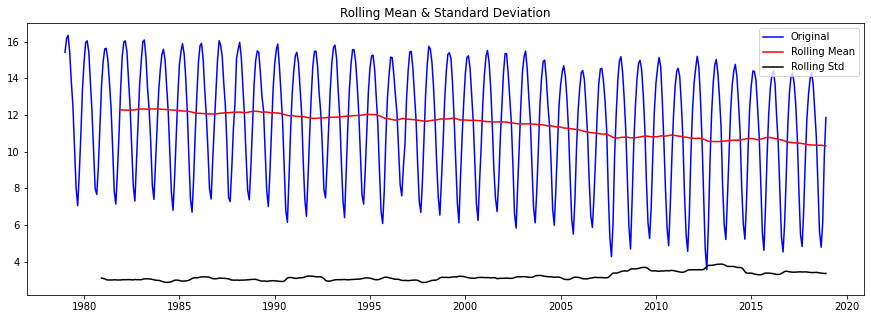

In [56]:
test_stationarity(ts)

### Differencing

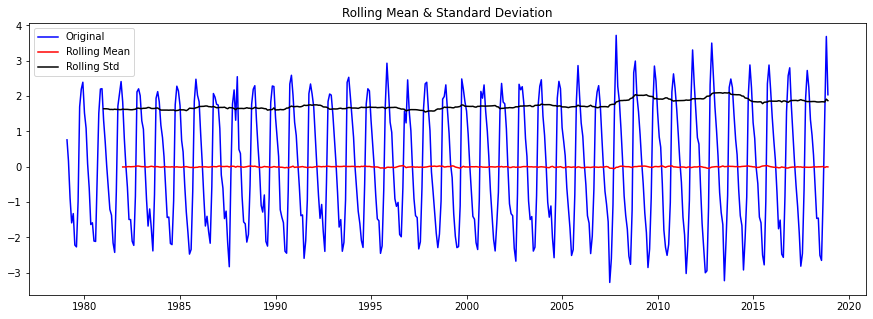

In [46]:
ts_diff = ts - ts.shift(1)
ts_diff = ts_diff.dropna()
test_stationarity(ts_diff)

### Cross validation setup

In [82]:
tscv = TimeSeriesSplit(n_splits = 18)
dataset = ts_diff[:-5] # need the -5 to get testsets for 24 months/2 years

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 300:

        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        print("TRAIN:", train_index.size) # visiualize cross_validation structure for reference
        print("TEST:", test_index.size)
        print()

TRAIN: 306
TEST: 24

TRAIN: 330
TEST: 24

TRAIN: 354
TEST: 24

TRAIN: 378
TEST: 24

TRAIN: 402
TEST: 24

TRAIN: 426
TEST: 24

TRAIN: 450
TEST: 24



###### test

In [ ]:
# setting up values for displaying prediction of the last 2 years
data = dataset
test_size = 24
data_train = data[:-test_size]
data_test = data[-test_size:]

C:\Users\Emiel\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.189735836655513


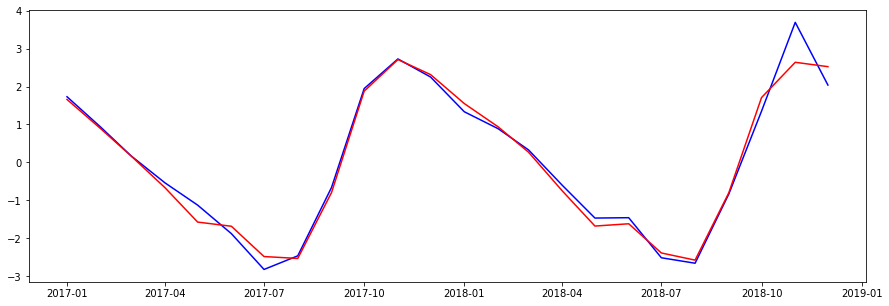

Wall time: 6.26 s


In [73]:
%%time
# singular test

import itertools
import warnings
import sys
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error



warnings.filterwarnings("ignore") # specify to ignore warning messages

# define model
model = SARIMAX(data_train, order=(2, 0, 1), seasonal_order=(12, 0, 1, 2))
# model = ARIMA(data_train, order=(7, 0, 8))

# fit model
model_fit = model.fit()

# one step forecast
# yhat = model_fit.forecast(steps=data_test.size)
yhat = model_fit.predict(start=len(data_train), end=len(data_train)+test_size-1, dynamic=False)

mae = mean_absolute_error(yhat, data_test)

# plot
print(mae)
plt.plot(data_test, color='blue')
plt.plot(yhat, color='red')
plt.show()

### ARIMA

In [157]:
%%time
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings
import sys
from sklearn.metrics import mean_absolute_error



# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 10)
d = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
best_pdq = pdq
best_mean_mae = np.inf
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    print(param)
    try:   # some parametercombinations might lead to crash, so catch exceptions and continue
        maes = []
        for train_index, test_index in tscv.split(dataset):
            if train_index.size > 300:
                # initialize cross validation train and test sets
                cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

                # build model
                model = ARIMA(cv_train, order=(param))
                model_fit = model.fit()

                # make predictions
                predictions =  model_fit.predict(start=len(cv_train), end=len(cv_train)+cv_test.size-1, dynamic=False)
                prediction_values = predictions.values
                true_values = cv_test.values
                # error calc
                #     print(true_values)
                #     print(predictions.values)
                maes.append(mean_absolute_error(true_values, prediction_values))

        
        mean_mae = np.mean(maes)
        print('MAE: ' + str(mean_mae))    

        if mean_mae < best_mean_mae:
            best_mean_mae = mean_mae
            best_maes = maes
            best_pdq = param
            best_predictions = prediction_values
    except Exception as e:
        print(e)
        continue
   
print()
print('Best MAE = ' + str(best_mean_mae))
print(best_pdq)


# best range(0,10)
# Best MAE = 0.23763938034311669
# (8, 0, 9)
# Wall time: 1h 32min 14s


(0, 0, 0)
MAE: 1.6366729662666217
(0, 0, 1)
MAE: 1.579581383464959
(0, 0, 2)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 3)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 4)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 5)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 6)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 7)
The computed initial MA coefficients are not invertible
You should induce

MAE: 1.6127171646210408
(2, 1, 1)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 1, 2)
MAE: 1.7296381234623333
(2, 1, 3)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 1, 4)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 1, 5)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 1, 6)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 1, 7)
The computed initial MA coefficients are not invertible
You should induce invertib

MAE: 1.6951769379332204
(4, 1, 3)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(4, 1, 4)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(4, 1, 5)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(4, 1, 6)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(4, 1, 7)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(4, 1, 8)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model or

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(7, 0, 0)
MAE: 0.6159636081035573
(7, 0, 1)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(7, 0, 2)
SVD did not converge
(7, 0, 3)
MAE: 0.2992014842236858
(7, 0, 4)
MAE: 0.2740301124954571
(7, 0, 5)
MAE: 0.2861416891877693
(7, 0, 6)
MAE: 0.28382223760054837
(7, 0, 7)
MAE: 0.2435447297297839
(7, 0, 8)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(7, 0, 9)
SVD did not converge
(7, 1, 0)
MAE: 1.649823530326478
(7, 1, 1)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(7, 1, 2)
SVD did not converge

SVD did not converge
(9, 2, 3)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(9, 2, 4)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(9, 2, 5)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(9, 2, 6)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(9, 2, 7)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(9, 2, 8)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order

In [160]:
# best_pdq = 

-------
IIIIIII
Mean MAE: 0.238 x 1 000 000 km²
MAE of last prediction: 0.193 x 1 000 000 km²
Execution time: 134.572 seconds


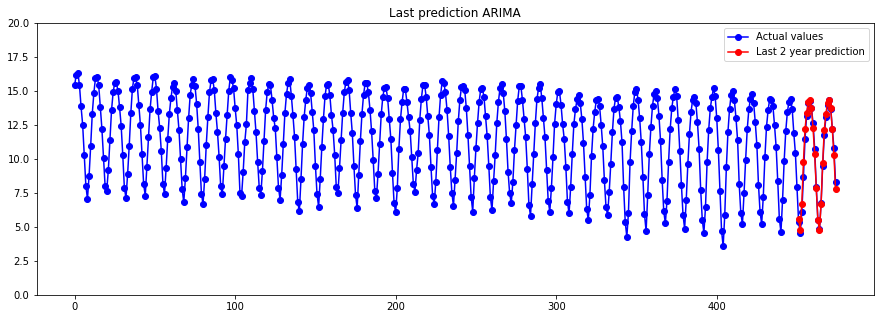

In [161]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error


start_time = timeit.default_timer()

warnings.filterwarnings("ignore") # specify to ignore warning messages

print("-------")

maes = []

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 300:
        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        # build model
        model = ARIMA(cv_train, order=(best_pdq))
        model_fit = model.fit()

        # make predictions
        predictions =  model_fit.predict(start=len(cv_train), end=len(cv_train)+cv_test.size-1, dynamic=False)
        prediction_values = predictions.values
        true_values = cv_test.values

        # error calc
    #     print(true_values)
    #     print(predictions.values)
        maes.append(mean_absolute_error(true_values, prediction_values))

        print("I",end="")

time_ARIMA = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_ARIMA = mae_mean
last_MAE_ARIMA = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_ARIMA)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_ARIMA)
print('Execution time: %.3f seconds' % time_ARIMA)
full_graph(prediction_values, 'Last prediction ARIMA')

### SARIMAX

#### Determine hyperparameters

In [ ]:
%%time
# SARIMAX

import itertools
import warnings
import sys
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Define the p, d and q parameters to take any value between 0 and 2
p = q = P = D = Q = range(0, 3)
d = D = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdqPDQ = list(itertools.product(p, d, q , P, D, Q))
best_pdqPDQ = pdqPDQ
best_mean_mae = np.inf
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdqPDQ:
    print(param)
    try:   # some parametercombinations might lead to crash, so catch exceptions and continue
        maes = []
        for train_index, test_index in tscv.split(dataset):
            if train_index.size > 300:
                # initialize cross validation train and test sets
                cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

                # build model
                model = SARIMAX(cv_train, 
                order=param[:3], 
                seasonal_order=(12,)+param[3:])
                model_fit = model.fit()

                # make predictions
                predictions =  model_fit.predict(start=len(cv_train), end=len(cv_train)+cv_test.size-1, dynamic=False)
                prediction_values = predictions.values
                true_values = cv_test.values
                # error calc
                #     print(true_values)
                #     print(predictions.values)
                maes.append(mean_absolute_error(true_values, prediction_values))

        
        mean_mae = np.mean(maes)
        print('MAE: ' + str(mean_mae))    

        if mean_mae < best_mean_mae:
            best_mean_mae = mean_mae
            best_maes = maes
            best_pdqPDQ = param
            best_predictions = prediction_values
    except Exception as e:
        print(e)
        continue

predictions_df = pd.DataFrame(best_predictions).set_index(keys=data_test.index)

# plot
print()
print('Best MAE = ' + str(best_mean_mae))
print(best_pdqPDQ)
plt.plot(data_test,color='blue')
plt.plot(predictions_df, color='red')
plt.show()

# best range(0,2):
# Best MAE = 0.2524024604742092
# (1, 0, 1, 1, 1, 1)
# Wall time: 14min 50s




(0, 0, 0, 0, 0, 0)
MAE: 0.259083718739363
(0, 0, 0, 0, 0, 1)
MAE: 0.259083718739363
(0, 0, 0, 0, 0, 2)
MAE: 0.23370666521763678
(0, 0, 0, 0, 1, 0)
MAE: 0.2588157022612497
(0, 0, 0, 0, 1, 1)
MAE: 0.2588157022612497
(0, 0, 0, 0, 1, 2)
MAE: 0.23419382710056882
(0, 0, 0, 1, 0, 0)
Invalid value for design matrix. Requires a 2- or 3-dimensional array, got 1 dimensions
(0, 0, 0, 1, 0, 1)
LU decomposition error.
(0, 0, 0, 1, 0, 2)
MAE: 0.2542257579001153
(0, 0, 0, 1, 1, 0)
Invalid value for design matrix. Requires a 2- or 3-dimensional array, got 1 dimensions
(0, 0, 0, 1, 1, 1)
MAE: 0.26313432207751747
(0, 0, 0, 1, 1, 2)
MAE: 0.23124656760115486
(0, 0, 0, 2, 0, 0)
Invalid value for design matrix. Requires a 2- or 3-dimensional array, got 1 dimensions
(0, 0, 0, 2, 0, 1)
MAE: 0.3654612955387209
(0, 0, 0, 2, 0, 2)
MAE: 0.28883047466196354
(0, 0, 0, 2, 1, 0)
Invalid value for design matrix. Requires a 2- or 3-dimensional array, got 1 dimensions
(0, 0, 0, 2, 1, 1)
LU decomposition error.
(0, 0, 0, 

MAE: 0.26474019127148435
(1, 0, 1, 2, 1, 2)
MAE: 0.2649031184173699
(1, 0, 2, 0, 0, 0)
MAE: 0.2602771530749342
(1, 0, 2, 0, 0, 1)
MAE: 0.2602771530749342
(1, 0, 2, 0, 0, 2)
MAE: 0.23380978073919806
(1, 0, 2, 0, 1, 0)
MAE: 0.2619487481230916
(1, 0, 2, 0, 1, 1)
MAE: 0.2619487481230916
(1, 0, 2, 0, 1, 2)
MAE: 0.22780663319275937
(1, 0, 2, 1, 0, 0)
Invalid value for design matrix. Requires a 2- or 3-dimensional array, got 1 dimensions
(1, 0, 2, 1, 0, 1)
MAE: 0.2632067290453656
(1, 0, 2, 1, 0, 2)
MAE: 0.23194229420084148
(1, 0, 2, 1, 1, 0)
Invalid value for design matrix. Requires a 2- or 3-dimensional array, got 1 dimensions
(1, 0, 2, 1, 1, 1)
MAE: 0.26906489861592225
(1, 0, 2, 1, 1, 2)
MAE: 0.23072011437047793
(1, 0, 2, 2, 0, 0)
Invalid value for design matrix. Requires a 2- or 3-dimensional array, got 1 dimensions
(1, 0, 2, 2, 0, 1)
MAE: 0.25427353818052933
(1, 0, 2, 2, 0, 2)


In [ ]:
# best_pdqPDQ = IMPLEMENT IN MODEL UNDER

In [ ]:
from sklearn.metrics import mean_absolute_error


start_time = timeit.default_timer()

warnings.filterwarnings("ignore") # specify to ignore warning messages

print("-------")

maes = []

for train_index, test_index in tscv.split(dataset):
    if train_index.size > 300:

        # initialize cross validation train and test sets
        cv_train, cv_test = dataset.iloc[train_index], dataset.iloc[test_index]

        # build model
        model = SARIMAX(cv_train, order=(1, 0, 1), seasonal_order=(12, 1, 1, 1))
        model_fit = model.fit()

        # make predictions
        predictions =  model_fit.predict(start=len(cv_train), end=len(cv_train)+cv_test.size-1, dynamic=False)
        prediction_values = predictions.values
        true_values = cv_test.values

        # error calc
    #     print(true_values)
    #     print(predictions.values)
        maes.append(mean_absolute_error(true_values, prediction_values))
        print("I",end="")



time_ARIMA = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_ARIMA = mae_mean
last_MAE_ARIMA = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_ARIMA)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_ARIMA)
print('Execution time: %.3f seconds' % time_ARIMA)
full_graph(prediction_values, 'Last prediction SARIMAX')

In [ ]:
# better mean but worse during testing
# model = SARIMAX(cv_train, order=(2, 0, 1), seasonal_order=(12, 0, 1, 2))
# Mean MAE: 0.329 x 1 000 000 km²
# MAE of last prediction: 0.153 x 1 000 000 km²
# Execution time: 32.421 seconds

### LSTM

In [17]:
import numpy as np

# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

def calc_rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0)) * 100

def monitor(name, variable):
    print(name)
    print(type(variable))
    print(variable)
    print()

# split a univariate dataset into train/test sets
def split_dataset(data):
    n_test_entries = 24
    # split into standard years
    train, test = data[:-n_test_entries], data[-n_test_entries:]
    # restructure into windows of yearly data
    train = array(split(train, len(train)/12))
    test = array(split(test, len(test)/12))
    return train, test

# evaluate one or more weekly forecasts against expected values
# MABEY?
# def evaluate_forecasts(actual, predicted):
#     monitor("Actual", actual)
#     monitor("Predicted",predicted)
#     print()
    
    
#     scores = list()
#     # calculate an RMSE score for each day
#     for i in range(actual.shape[1]):
#         # calculate rmspe
#         rmspe = calc_rmspe(actual[:, i], predicted[:, i])
#         # store
#         scores.append(rmspe)
        
# #     # calculate overall RMSE
# #     s = 0
# #     for row in range(actual.shape[0]):
# #         for col in range(actual.shape[1]):
# #             s += (actual[row, col] - predicted[row, col])**2
#     score = calc_rmspe(actual.flatten(),predicted.flatten())
#     return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=12):
    # flatten data
    print(train.shape)
    data = train.reshape((train.shape[0]*train.shape[1]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # plot history
    pyplot.title('Error per epoch')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.legend()
    pyplot.show()
    return model

# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1]))
    # retrieve last observations for input data
    input_x = data[-n_input:]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
    # fit model
    model = build_model(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score = calc_rmspe(test[:, :].flatten(), predictions.flatten()) #evaluate_forecasts(test[:, :, 0], predictions)
    X = range(0,24)
    pyplot.title('Comparing actual results with predictions')
    pyplot.plot(X, test[:, :].flatten(), marker='o', label='Actual')
    pyplot.plot(X, predictions.flatten(), marker='o', label='Predictions')
    pyplot.legend()
    pyplot.show()
    return score, r2_score(test[:, :].flatten(), predictions.flatten()), predictions

In [18]:
# load the new file
dataset = ts
data = dataset.values

In [19]:
# split into train and test
train, test = split_dataset(data)

In [20]:
train

array([[[-2.54982079],
        [-1.33710317],
        [ 2.93207885],
        [10.22981481],
        [12.79677419],
        [16.03481481],
        [19.2765233 ],
        [16.84408602],
        [15.1287037 ],
        [10.12885305],
        [ 5.26611111],
        [ 1.41021505]],

       [[ 3.30716846],
        [ 2.88154762],
        [ 6.38817204],
        [ 8.02537037],
        [14.45089606],
        [17.66518519],
        [19.25376344],
        [19.94086022],
        [11.71111111],
        [ 8.42508961],
        [ 2.69962963],
        [-1.43924731]],

       [[-0.36792115],
        [ 1.38122605],
        [ 5.17903226],
        [ 9.27462963],
        [13.4844086 ],
        [18.05740741],
        [18.39928315],
        [19.14964158],
        [13.76740741],
        [10.04498208],
        [ 5.29055556],
        [ 2.33530466]],

       [[-2.11362007],
        [ 0.43650794],
        [ 4.30107527],
        [10.83333333],
        [13.79928315],
        [15.60722222],
        [19.15770609],
     

In [21]:
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 12

(9, 12, 1)


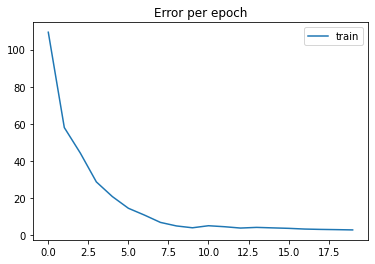

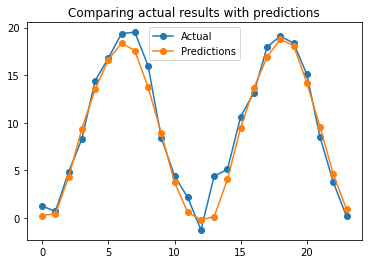

RMSPE: 95.47118118913284
R2: 0.9620053022290957


In [37]:
# define the total days to use as input
n_input = n_length * n_steps
rmspe_LSTM, rsq_LSTM, predictions = evaluate_model(train, test, n_steps, n_length, n_input)
print('RMSPE: '+str(rmspe_LSTM))
print('R2: '+ str(rsq_LSTM))

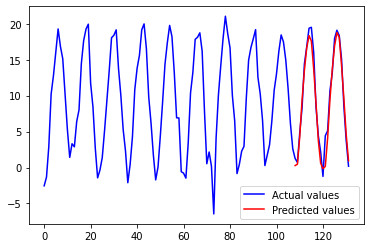

In [38]:
full_graph(predictions)

### Normale polynomiale regressie

In [39]:
tspr = ts.reset_index().reset_index()

In [40]:
tspr = tspr.sort_values('Date')

In [41]:
X = tspr.index.values
y = tspr.iloc[:, 2].values

In [44]:
tspred = ts

In [45]:
degree = 5

In [50]:
X

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131], dtype=int64)

In [58]:
X_train = X[:-testSize]
y_train = y[:-testSize]
X_test = X[-testSize:]
y_test = y[-testSize:]

In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Prepare variables that keep track of the best fitting polynomial
BestR2 = -float('inf')
BestRMSPE = float('inf')
BestIR2 = 1
BestIRMSPE = 1



# Loop over polynomials from degrees 1 to 10 and use polynomial that fits best according to the 
for i in range(1,10):
    
    # Create PolynomialFeatures from the first degree
    poly = PolynomialFeatures(degree=i)
    
    # Fit the inputdata from your trainingsset to the polynomial
    X_train_transform = poly.fit_transform(X_train.reshape(X_train.size,1))
    
    # Create the model and fit it to the transformed inputdata and your expected outputdata from the trainingsdata
    model = LinearRegression()
    model.fit(X_train_transform,y_train)
    
    # Transform the inputdata from your 
    X_test_transform = poly.fit_transform(X_test.reshape(X_test.size,1))
    y_predict_test = model.predict(X_test_transform)    
    
    # Calculate errors
    RMSPE_test = calc_rmspe(y_test, y_predict_test)

    # Print errors
    print('RMSPE for i = ' + str(i) + ' is ' + str(RMSPE_test) )
    print()
    
    # Update best fit
    if BestRMSPE > RMSPE_test:
        BestRMSPE = RMSPE_test
        BestRMSPEi = i
        
# Conclude best results
# print('Best i value according to r2 is '+str(BestR2i)+' with r2: '+str(BestR2))
print('Best i value according to RMSPE is '+str(BestRMSPEi)+' with RMSPE: '+str(BestRMSPE))

RMSPE for i = 1 is 1217.7156111178756

RMSPE for i = 2 is 1239.3367071090183

RMSPE for i = 3 is 2060.5818963830507

RMSPE for i = 4 is 329.0344532046938

RMSPE for i = 5 is 3369.940396923836

RMSPE for i = 6 is 19451.914134853363

RMSPE for i = 7 is 13287.430142736337

RMSPE for i = 8 is 34102.30076532954

RMSPE for i = 9 is 198058.559715345

Best i value according to RMSPE is 4 with RMSPE: 329.0344532046938


In [60]:
y_test

array([ 1.26899642,  0.70436508,  4.84641577,  8.30407407, 14.40860215,
       16.79444444, 19.37795699, 19.51003584, 16.01537037,  8.44982079,
        4.42925926,  2.16308244, -1.24157706,  4.42337165,  5.10985663,
       10.66203704, 13.15734767, 17.97203704, 19.10017921, 18.36397849,
       15.08777778,  8.48799283,  3.75981481,  0.17670251])

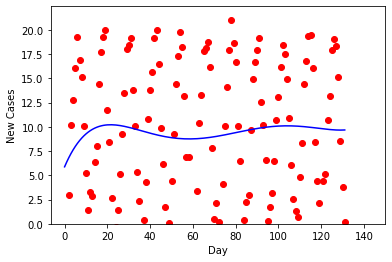

In [61]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


poly_reg = PolynomialFeatures(degree=degree)

X_poly = poly_reg.fit_transform(X.reshape(-1,1))
pol_reg = LinearRegression()
pol_reg.fit(X_poly
, y)
# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X.reshape(-1,1))), color='blue')
    plt.title('')
    plt.xlabel('Day')
    plt.ylabel('New Cases')
    plt.ylim(bottom=0)
    plt.xlim(right=150)
    plt.show()
    return
viz_polymonial()

In [62]:
testsize = int(ts.shape[0]/3)

tspred = tspred[:-testsize]

In [63]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


poly_reg = PolynomialFeatures(degree=degree)

X_poly = poly_reg.fit_transform(X.reshape(-1,1))
pol_reg = LinearRegression(fit_intercept=True)
pol_reg.fit(X_poly, y)

i = ts.shape[0] - (ts.shape[0]/3)

while i <= tsuv.shape[0] :
    tspred = tspred.append({'Temperature': pol_reg.predict(poly_reg.fit_transform([[i]]))[0]}, ignore_index=True)
    i += 1

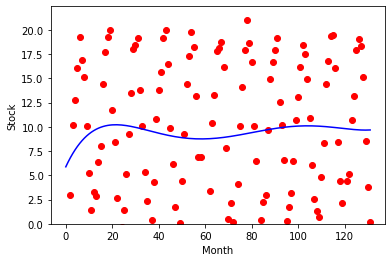

In [66]:
plt.scatter(X, y, color='red')
plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X.reshape(-1,1))), color='blue')
plt.title('')
plt.xlabel('Month')
plt.ylabel('Stock')
plt.ylim(bottom=0)
plt.show()

In [67]:
tspred

,Temperature
0,-2.549821
1,-1.337103
2,2.932079
3,10.229815
4,12.796774
...,...
128,9.665146
129,9.662532
130,9.665745
131,9.675541


array([10.0677759 , 10.05316045, 10.03623378, 10.01716946,  9.99616521,
        9.97344362,  9.94925287,  9.92386748,  9.89758903,  9.87074692,
        9.84369909,  9.81683274,  9.79056511,  9.76534417,  9.74164938,
        9.71999244,  9.70091798,  9.68500433,  9.67286426,  9.66514569,
        9.66253245,  9.665745  ,  9.67554116,  9.6927169 ])

In [83]:
y_pred = tspred[-testSize:].values.flatten()

In [84]:
rmspe_PR = calc_rmspe(y_test, y_pred)
rsq_PR =  r2_score(y_test, y_pred)
print('RMSPE_PR '+str(rmspe_PR))
print('RSQ_PR '+str(rsq_PR))

RMSPE_PR 1159.2288378677908
RSQ_PR -0.0063831454516967145


### Fit to sin function

In [106]:
# testing
# https://towardsdatascience.com/fitting-cosine-sine-functions-with-machine-learning-in-python-610605d9b057

In [107]:
import numpy as np
seed = 12345512
np.random.seed(seed)

n = 100
x_data = np.linspace(-5, 5, num=n)
y_data = 10 + 5 * np.cos(3 * x_data + 2) + 1.5 * np.random.normal(size=n)

In [108]:
values_scaledup =tsuv.values.flatten().astype(int)*1000
x_data = np.array(range(tsuv.values.size))
y_data = values_scaledup

In [109]:
# random split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = x_data[:-24], x_data[-24:], y_data[:-24], y_data[-24:]

In [110]:
from scipy import optimize
from IPython.display import display, Math

def test_func(x, dist, amp, omega, phi):
    return dist + amp * np.cos(omega * x + phi)

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data, p0=[1, 1, 2, 1])

print('Fitted parameters:')
display(Math('a_0={:.2f}, a_1={:.2f}, \\omega={:.2f}, \\phi={:.2f}'.format(*params)))
print('Original parameters:')
display(Math('a_0={:.2f}, a_1={:.2f}, \\omega={:.2f}, \\phi={:.2f}'.format(*[10.0, 5.0, 3.0, 2.0])))

Fitted parameters:


<IPython.core.display.Math object>

Original parameters:


<IPython.core.display.Math object>

In [111]:
def objective(a0, a1, w, f):
    """Objective function to minimize"""
    return np.mean((a0+ a1 * np.cos(w*X_train + f) - y_train)**2)

def objective2(args):
    return objective(*args)

In [112]:
# ! pip install hyperopt

In [113]:
from hyperopt import hp, tpe, Trials, fmin
from IPython.display import display, Math

space = [hp.uniform('a0', 5, 15),
         hp.uniform('a1', 0, 10), 
         hp.uniform('w', 0, 10), 
         hp.uniform('f', -np.pi, np.pi)]

tpe_algo = tpe.suggest
tpe_trials = Trials()

tpe_best = fmin(fn=objective2, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=500, rstate=np.random.RandomState(seed))

print('Fitted parameters:')
display(Math('a_0={a0:.2f}, a_1={a1:.2f}, \\omega={w:.2f}, \\phi={f:.2f}'.format(**tpe_best)))
print('Original parameters:')
display(Math('a_0={:.2f}, a_1={:.2f}, \\omega={:.2f}, \\phi={:.2f}'.format(*[10.0, 5.0, 3.0, 2.0])))


100%|█████████████████████████████████████████████| 500/500 [00:03<00:00, 134.27trial/s, best loss: 129240774.82530499]
Fitted parameters:


<IPython.core.display.Math object>

Original parameters:


<IPython.core.display.Math object>

In [114]:
! pip install HOBBIT

In [115]:
# https://github.com/Harmonic-Oscillator-hyBrid-fIT/HOBIT

In [116]:
from HOBIT import RegressionForTrigonometric
from IPython.display import display, Math

trig_reg = RegressionForTrigonometric()
trig_reg.fit_cos(X_train, y_train, max_evals=500, rstate=np.random.RandomState(seed))

print('Fitted parameters:')
display(Math('a_0={intercept:.2f}, a_1={amplitude:.2f}, \\omega={omega:.2f}, \\phi={phi:.2f}'.format(**trig_reg.best_parameters)))
print('Original parameters:')
display(Math('a_0={:.2f}, a_1={:.2f}, \\omega={:.2f}, \\phi={:.2f}'.format(*[10.0, 5.0, 3.0, 2.0])))


100%|█████████████████████████████████████████████| 500/500 [00:03<00:00, 163.99trial/s, best loss: 14284937.445426818]
Fitted parameters:


<IPython.core.display.Math object>

Original parameters:


<IPython.core.display.Math object>

In [117]:
y_pred

array([ 0.14177273, -0.2752886 ,  1.68880729,  5.52359501, 10.23241932,
       14.59146427, 17.46782102, 18.11392902, 16.36186584, 12.66698989,
        7.98959358,  3.54532475,  0.48924181, -0.38438415,  1.15150088,
        4.69772281,  9.3326242 , 13.85160157, 17.08017986, 18.17925673,
       16.86318384, 13.47400645,  8.89256636,  4.30957257])

array([ 1.26899642,  0.70436508,  4.84641577,  8.30407407, 14.40860215,
       16.79444444, 19.37795699, 19.51003584, 16.01537037,  8.44982079,
        4.42925926,  2.16308244, -1.24157706,  4.42337165,  5.10985663,
       10.66203704, 13.15734767, 17.97203704, 19.10017921, 18.36397849,
       15.08777778,  8.48799283,  3.75981481,  0.17670251])

In [130]:
from sklearn.metrics import mean_squared_error, r2_score

scaled_ypred = trig_reg.predict(X_test)

y_pred = scaled_ypred/1000
y_test = ts[-testSize:].values.flatten()

rmspe_PR2 = calc_rmspe(y_test, y_pred)
rsq_PR2 = r2_score(y_test,ypred)
print('rmspe:', rmspe_PR2)
print('r2:',rsq_PR2)

rmspe: 482.237629623344
r2: 0.7668160754594008


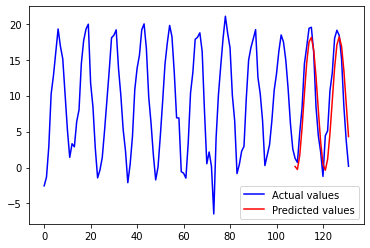

In [132]:
full_graph(ypred)

### Evaluation

In [133]:
print('ARIMA RMSE:\t %.3f' % rmspe_ARIMA)
print('ARIMA r2:\t %.3f' % rsq_ARIMA)
print()
print('SARIMAX RMSE:\t %.3f' % rmspe_SARIMAX)
print('SARIMAX r2:\t %.3f' % rsq_SARIMAX)
print()
print('LSTM RMSE:\t %.3f' % rmspe_LSTM)
print('LSTM r2:\t %.3f' % rsq_LSTM)
print()
print('PR RMSE:\t %.3f' % rmspe_PR)
print('PR r2:\t\t %.3f' % rsq_PR)
print()
print('PR Sin RMSE:\t %.3f' % rmspe_PR2)
print('PR Sin r2:\t %.3f' % rsq_PR2)

ARIMA RMSE:	 102.451
ARIMA r2:	 0.972

SARIMAX RMSE:	 154.524
SARIMAX r2:	 0.969

LSTM RMSE:	 95.471
LSTM r2:	 0.962

PR RMSE:	 1159.229
PR r2:		 -0.006

PR Sin RMSE:	 482.238
PR Sin r2:	 0.767
